In [2]:
import tensorflow as tf
from tensorflow import keras  
import numpy as np
import pandas as pd
from numpy.random import randint
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

at_home = True

if at_home == True:
    checkpoint1_path = 'model_weights_home/cp-{epoch:04d}.ckpt'
    checkpoint2_path = 'binary_model_weights_home/cp-{epoch:04d}.ckpt'
else:
    checkpoint1_path = 'model_weights_uni/cp-{epoch:04d}.ckpt'
    checkpoint2_path = 'binary_model_weights_uni/cp-{epoch:04d}.ckpt'

2023-03-03 20:06:36.811162: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 20:06:37.005586: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-03 20:06:38.078430: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/saashiv/miniconda3/envs/tf/lib/
2023-03-03 20:06:38.078629: W tensorflow/compiler/xla/strea

In [3]:
print('image classes')
image_classes = np.loadtxt('labels-map-proj-v3.txt',dtype=str,delimiter=' ')

print('dataframe')
df =pd.DataFrame(image_classes,columns=['filename','class'])

print('shuffling')
df = shuffle(df)

print('traintestsplit')
train_df,test_df = train_test_split(df,test_size=0.2)
train_df,val_df = train_test_split(train_df,test_size=0.5)

print('image generator')
idg = ImageDataGenerator(rescale=1./255.) # normalize
batchsize=128

print('batching')
train_ds = idg.flow_from_dataframe(dataframe=train_df, directory='map-proj-v3',batch_size=batchsize)
test_ds  = idg.flow_from_dataframe(dataframe= test_df, directory='map-proj-v3',batch_size=batchsize)
val_ds =   idg.flow_from_dataframe(dataframe=  val_df, directory='map-proj-v3',batch_size=batchsize)

image classes
dataframe
shuffling
traintestsplit
image generator
batching
Found 29212 validated image filenames belonging to 8 classes.
Found 14607 validated image filenames belonging to 8 classes.
Found 29212 validated image filenames belonging to 8 classes.


In [4]:
print(df)

                                filename class
59692  ESP_017001_1805_RED-0204-r270.jpg     2
17603    ESP_023382_1845_RED-0121-fv.jpg     0
52092    PSP_008027_2070_RED-0197-fv.jpg     0
26553  ESP_016781_2055_RED-0189-r180.jpg     0
692     ESP_037610_1845_RED-0074-brt.jpg     0
...                                  ...   ...
21849  ESP_011881_1585_RED-0019-r180.jpg     0
4357   ESP_016814_2125_RED-0055-r270.jpg     0
12420  PSP_006879_2335_RED-0340-r180.jpg     0
30496    PSP_008965_1510_RED-0823-fh.jpg     0
23269   ESP_036804_2345_RED-0343-r90.jpg     0

[73031 rows x 2 columns]


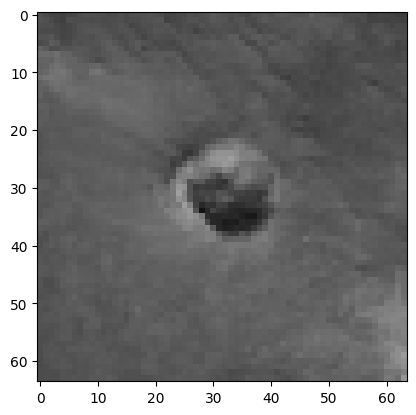

In [49]:
resize = 64
image_test = tf.image.resize(
    train_ds[0][0][0],
    [resize,resize])

plt.imshow(image_test)

In [6]:
BatchSize       = batchsize
Nepochs         = 5
DropoutValue    = 0.6 # currently unused
# set resize in previous cell

zpix = train_ds[0][0][0].shape[2] #colour

input_shape=(0,resize, resize, zpix)

model = keras.models.Sequential()

model.add(keras.layers.Lambda(lambda image:tf.image.resize(image,[resize,resize])))

model.add(keras.layers.Conv2D(32, (3, 3), padding ='same',activation='relu', input_shape=(resize, resize, zpix)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(8, activation='softmax'))

print("--------------------------------------------------------------------------------------------------------------")
print("\033[92mWill train a convolutional neural network on the MNIST data\033[0m")
print("--------------------------------------------------------------------------------------------------------------\n\n")
print("Input data MNIST")
print("Dropout values       = ", DropoutValue)
print("Leaky relu parameter =  0.1")
print("BatchSize            = ", batchsize)
print("Nepochs              = ", Nepochs, "\n")

loss_fn = keras.losses.CategoricalCrossentropy()

model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')
checkpoint_path = checkpoint1_path
checkpoint_dir  = os.path.dirname(checkpoint_path)
cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True)

model.build(input_shape) # in week 4 CNN.ipynb Abbey didn't have model.build but her summary works, how?
model.summary()

history  = model.fit(train_ds, validation_data=val_ds,batch_size=batchsize,epochs=Nepochs,callbacks=[tensorboard_callback,cp_callback])

--------------------------------------------------------------------------------------------------------------
Will train a convolutional neural network on the MNIST data
--------------------------------------------------------------------------------------------------------------


Input data MNIST
Dropout values       =  0.6
Leaky relu parameter =  0.1
BatchSize            =  128
Nepochs              =  5 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (0, 64, 64, 3)            0         
                                                                 
 conv2d (Conv2D)             (0, 64, 64, 32)           896       
                                                                 
 max_pooling2d (MaxPooling2D  (0, 32, 32, 32)          0         
 )                                                               
                                       

2023-03-03 18:49:36.519394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-03 18:49:37.653422: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-03 18:49:38.964180: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-03 18:49:39.009340: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1deab050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-03 18:49:39.009380: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-03-03 18:49:39.044449: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-03 18:49:39.265935: I

229/229 [==============================] - ETA: 0s - loss: 0.6500 - accuracy: 0.8350
Epoch 1: saving model to model_weights/cp-0001.ckpt
229/229 [==============================] - 52s 205ms/step - loss: 0.6500 - accuracy: 0.8350 - val_loss: 0.5663 - val_accuracy: 0.8484
Epoch 2/5
229/229 [==============================] - ETA: 0s - loss: 0.5000 - accuracy: 0.8579
Epoch 2: saving model to model_weights/cp-0002.ckpt
229/229 [==============================] - 50s 220ms/step - loss: 0.5000 - accuracy: 0.8579 - val_loss: 0.4421 - val_accuracy: 0.8693
Epoch 3/5
229/229 [==============================] - ETA: 0s - loss: 0.4268 - accuracy: 0.8732
Epoch 3: saving model to model_weights/cp-0003.ckpt
229/229 [==============================] - 41s 181ms/step - loss: 0.4268 - accuracy: 0.8732 - val_loss: 0.4175 - val_accuracy: 0.8773
Epoch 4/5
229/229 [==============================] - ETA: 0s - loss: 0.3780 - accuracy: 0.8859
Epoch 4: saving model to model_weights/cp-0004.ckpt
229/229 [===========

In [7]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)
loss, acc = model.evaluate(test_ds)

115/115 [==============================] - 17s 145ms/step - loss: 0.3554 - accuracy: 0.8901


history keys =  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Display the evolution of the accuracy as a function of the training epoch
  N(Epochs)        =  5
  accuracy (train) =  [0.8349993228912354, 0.8579350709915161, 0.8732370138168335, 0.8858688473701477, 0.895043134689331]
  accuracy (test)  =  [0.8483842015266418, 0.8693345189094543, 0.8773106932640076, 0.8798781037330627, 0.887751579284668]

Display the evolution of the loss as a function of the training epoch
  N(Epochs)        =  5
  loss (train)     =  [0.6500003337860107, 0.49996042251586914, 0.4268108904361725, 0.3780185878276825, 0.3362661898136139]


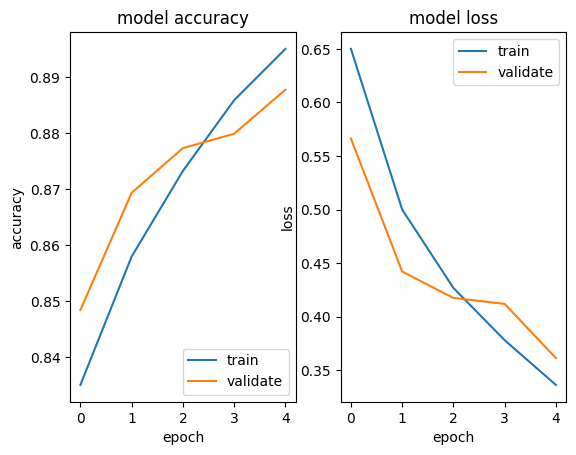

In [8]:
# Print out the history keys expected are:
#    loss        The loss function evaluated at each epoch for the training set
#    acc         The accuracy evaluated at each epoch for the training set
#    val_loss    The loss evaluated at each epoch for the validation set
#    val_acc     The accuracy evaluated at each epoch for the validation set
# The val_* entries exist only if there is a validation_split specified

print("history keys = ", history.history.keys())

print("\n\033[1mDisplay the evolution of the accuracy as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)

print("  accuracy (train) = ", history.history['accuracy'])
print("  accuracy (test)  = ", history.history['val_accuracy'])
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

print("\n\033[1mDisplay the evolution of the loss as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)
print("  loss (train)     = ", history.history['loss'])
#print("  loss (test)      = ", history.history['val_loss'])

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [9]:
predictions = model.predict(test_ds)

115/115 [==============================] - 32s 281ms/step


In [10]:
import csv

# Create an empty dictionary to store the data
data_dict = {}

with open('landmarks_map-proj-v3_classmap.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        # Get the number and word values from the current row
        num = int(row[0])
        word = row[1]
        # Add the values to the dictionary
        data_dict[num] = word

slope streak


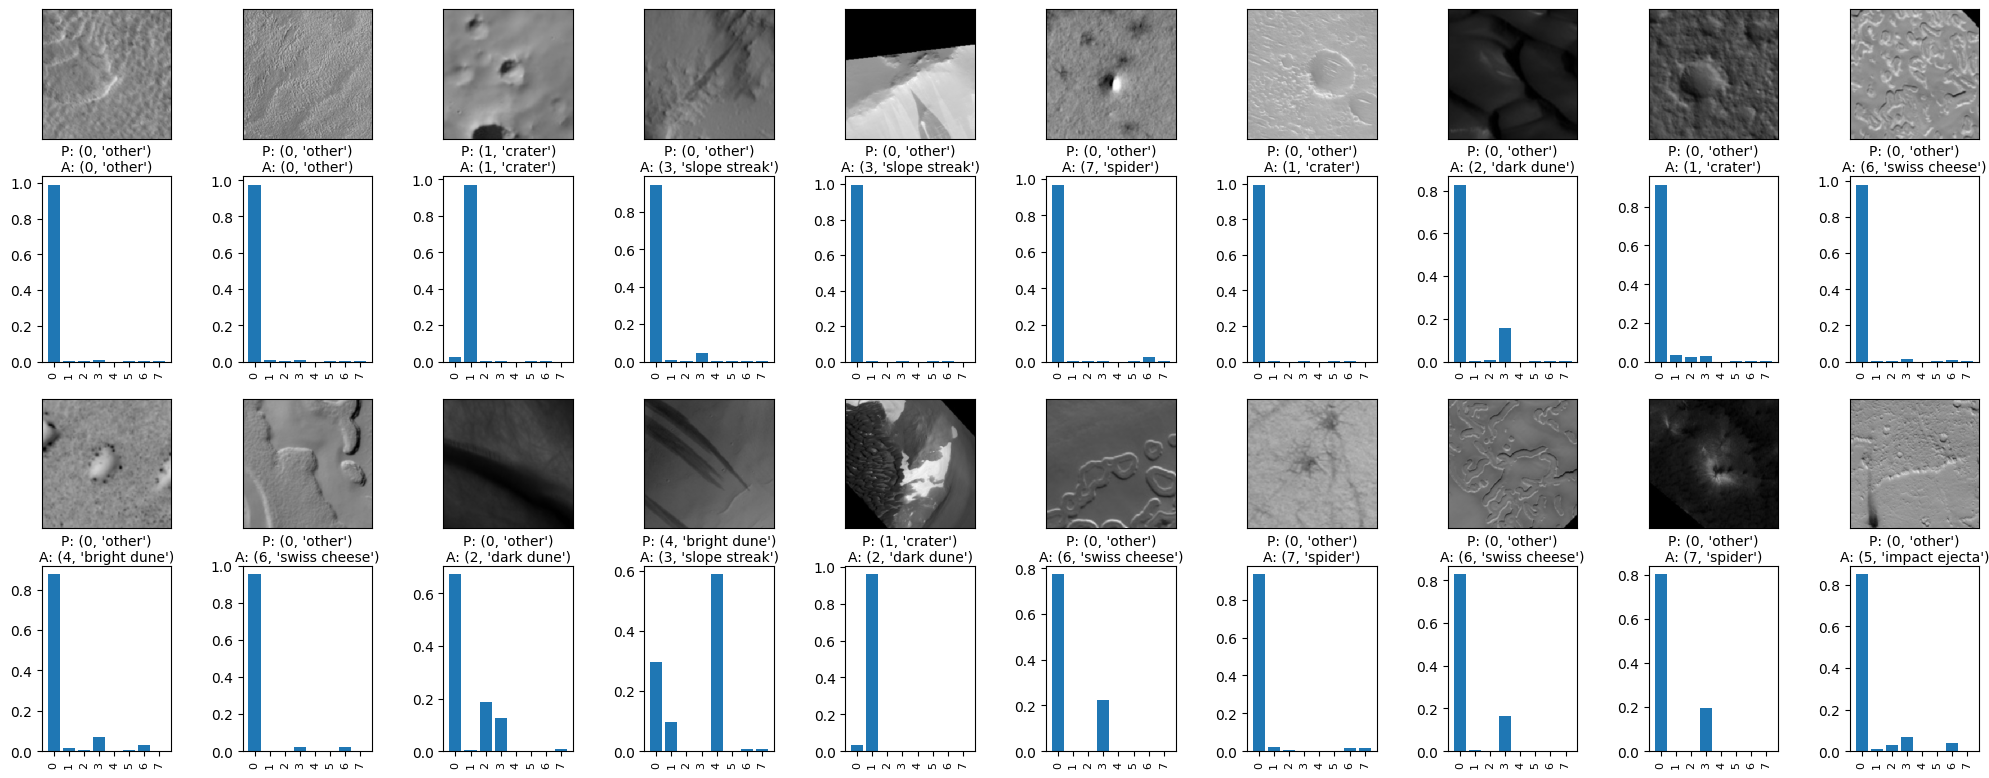

In [19]:
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(25, 10))
class_list = [i for i in range(0,8)]

rand_list = list(randint(0,8,12))
for i in rand_list:
    class_list.append(i)
count = 0
j = 0
x,y = 0,1
image_count = 0
for i in test_ds:
    image_count = 0
    for k in i[1]:
        prediction = predictions[count]
        actual = np.argmax(k)
        if np.isin(actual,class_list):

            axes[x][j].imshow(i[0][image_count])
            axes[x][j].set_xticks([])
            axes[x][j].set_yticks([])

            # Set the x axis label
            axes[x][j].set_xlabel(f"P: {np.argmax(prediction),data_dict[int(np.argmax(prediction))]}\nA: {actual, data_dict[actual]}",fontsize=10)

            # Add some space between subplots
            plt.subplots_adjust(wspace=0.55)
            plt.subplots_adjust(hspace=0.05)

            # Plot the predicted probabilities as a bar graph
            axes[y][j].bar([0,1,2,3,4,5,6,7],prediction)
            axes[y][j].set_xticks([0,1,2,3,4,5,6,7])
            axes[y][j].set_xticklabels([0,1,2,3,4,5,6,7], rotation=90, fontsize=8)

            class_list.remove(int(actual))

            j += 1
    
        image_count += 1
        count += 1

        if len(class_list) == 10:
            x,y,j=2,3,0
        if class_list == []:
            break
    if class_list == []:
        break

In [12]:
abs_predictions = np.argmax(predictions,axis=1)
test_df['models class'] = abs_predictions
test_df.head(20)

,filename,class,models class
30071,ESP_027564_1655_RED-0096-brt.jpg,0,0
44260,PSP_005457_2030_RED-0074-brt.jpg,0,0
17235,PSP_007489_1965_RED-0071-r90.jpg,0,0
27496,ESP_016659_1710_RED-0240.jpg,0,1
16568,ESP_025758_1475_RED-0274-brt.jpg,0,0
49778,ESP_016568_1710_RED-0040-r90.jpg,0,1
37059,ESP_019263_2650_RED-0068-r90.jpg,0,0
72650,ESP_019559_1390_RED-0951-fh.jpg,2,0
26496,ESP_019559_1390_RED-0841-r90.jpg,0,0
22431,PSP_010587_1620_RED-0113-r270.jpg,0,0


[91.87597152908451, 4.401228249744114, 0.8547008547008548, 0.0, 1.1173184357541899, 0.0, 0.0, 0.0]


Text(0, 0.5, 'prediction accuracy')

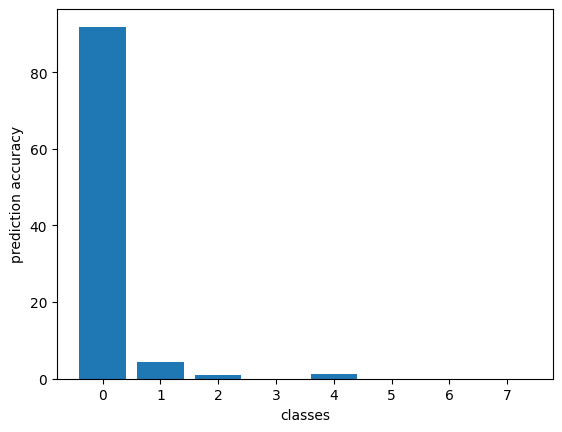

In [28]:
# for some reason class was a column of strings... took ages to figure that out
test_df['class'] = test_df['class'].astype(int)
class_list = [i for i in range(0,8)]

accuracy_list = []
for i in class_list:
    
    # select only rows with class equal to 0
    df_0 = test_df.loc[test_df['class'] == i]

    # calculate the number of rows where class and models class are identical
    num_identical = sum(df_0['class'] == df_0['models class'])

    # calculate the total number of rows
    num_rows = len(df_0)

    # calculate the percentage of rows where class and models class are identical
    percent_identical = num_identical / num_rows * 100
    
    accuracy_list.append(percent_identical)

print(accuracy_list)
plt.bar(class_list,accuracy_list)
plt.xlabel('classes')
plt.ylabel('prediction accuracy')

### changing to is/is not:[dune]

In [16]:
print('image classes')
image_classes = np.loadtxt('labels-map-proj-v3.txt',dtype=str,delimiter=' ')

print('dataframe')
df =pd.DataFrame(image_classes,columns=['filename','class'])

print('shuffling')
df = shuffle(df)

# Replace non-dune class labels with 0 & again with the string values for class. whyyyyyyyyyyy
df['class'] = df['class'].astype(int)
df.loc[~df['class'].isin([2, 4]), 'class'] = 0
df['class'] = df['class'].astype(str)

print('traintestsplit')
train_df,test_df = train_test_split(df,test_size=0.2)
train_df,val_df = train_test_split(train_df,test_size=0.5)

print('image generator')
idg = ImageDataGenerator(rescale=1./255.) # normalize
batchsize= 128
resize = 64
# and now the classes have to be strings again... whhhhhhhhhhhhhhhhhhyyyyyyyyyyyyyyyy
print('batching')
train_ds = idg.flow_from_dataframe(dataframe=train_df, directory='map-proj-v3',batch_size=batchsize)
test_ds  = idg.flow_from_dataframe(dataframe= test_df, directory='map-proj-v3',batch_size=batchsize)
val_ds =   idg.flow_from_dataframe(dataframe=  val_df, directory='map-proj-v3',batch_size=batchsize)

image classes
dataframe
shuffling
traintestsplit
image generator
batching
Found 29212 validated image filenames belonging to 3 classes.
Found 14607 validated image filenames belonging to 3 classes.
Found 29212 validated image filenames belonging to 3 classes.


In [17]:
BatchSize       = batchsize
Nepochs         = 5
DropoutValue    = 0.6 # currently unused
# set resize in previous cell

zpix = train_ds[0][0][0].shape[2] #colour

input_shape=(0,resize, resize, zpix)

model = keras.models.Sequential()

model.add(keras.layers.Lambda(lambda image:tf.image.resize(image,[resize,resize])))

model.add(keras.layers.Conv2D(32, (3, 3), padding ='same',activation='relu', input_shape=(resize, resize, zpix)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

print("--------------------------------------------------------------------------------------------------------------")
print("\033[92mWill train a convolutional neural network on the MNIST data\033[0m")
print("--------------------------------------------------------------------------------------------------------------\n\n")
print("Input data MNIST")
print("Dropout values       = ", DropoutValue)
print("Leaky relu parameter =  0.1")
print("BatchSize            = ", batchsize)
print("Nepochs              = ", Nepochs, "\n")


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')
checkpoint_path = checkpoint2_path
checkpoint_dir  = os.path.dirname(checkpoint_path)
cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True)

model.build(input_shape) # in week 4 CNN.ipynb Abbey didn't have model.build but her summary works, how?
model.summary()

history  = model.fit(train_ds, validation_data=val_ds,batch_size=batchsize,epochs=Nepochs,callbacks=[tensorboard_callback,cp_callback])

--------------------------------------------------------------------------------------------------------------
Will train a convolutional neural network on the MNIST data
--------------------------------------------------------------------------------------------------------------


Input data MNIST
Dropout values       =  0.6
Leaky relu parameter =  0.1
BatchSize            =  128
Nepochs              =  5 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (0, 64, 64, 3)            0         
                                                                 
 conv2d_3 (Conv2D)           (0, 64, 64, 32)           896       
                                                                 
 max_pooling2d_3 (MaxPooling  (0, 32, 32, 32)          0         
 2D)                                                             
                                     

ValueError: in user code:

    File "/home/saashiv/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/saashiv/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/saashiv/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/saashiv/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1028, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/saashiv/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1122, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/saashiv/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 577, in update_state
        self.build(y_pred, y_true)
    File "/home/saashiv/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 483, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(
    File "/home/saashiv/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 631, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/home/saashiv/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 631, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/home/saashiv/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 650, in _get_metric_object
        metric_obj = metrics_mod.get(metric)
    File "/home/saashiv/miniconda3/envs/tf/lib/python3.9/site-packages/keras/metrics/__init__.py", line 181, in get
        return deserialize(str(identifier))
    File "/home/saashiv/miniconda3/envs/tf/lib/python3.9/site-packages/keras/metrics/__init__.py", line 136, in deserialize
        return deserialize_keras_object(
    File "/home/saashiv/miniconda3/envs/tf/lib/python3.9/site-packages/keras/saving/legacy/serialization.py", line 557, in deserialize_keras_object
        raise ValueError(

    ValueError: Unknown metric function: 'ROC'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


history keys =  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Display the evolution of the accuracy as a function of the training epoch
  N(Epochs)        =  5
  accuracy (train) =  [0.6662330031394958, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368, 0.6666666269302368]
  accuracy (test)  =  [0.666666567325592, 0.666666567325592, 0.666666567325592, 0.666666567325592, 0.666666567325592]

Display the evolution of the loss as a function of the training epoch
  N(Epochs)        =  5
  loss (train)     =  [0.6397144198417664, 0.6365218758583069, 0.6365198493003845, 0.6365167498588562, 0.6365178227424622]


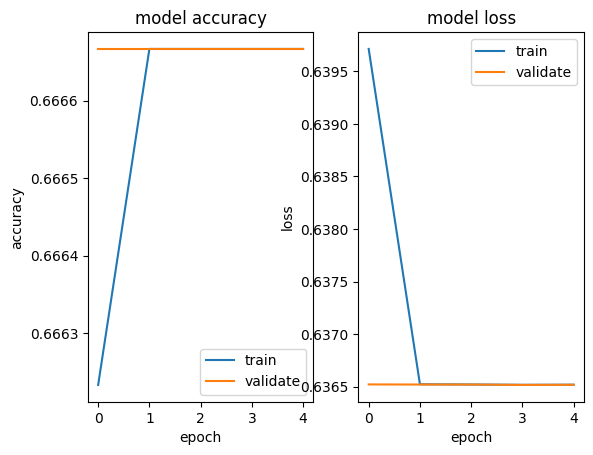

In [7]:
# Print out the history keys expected are:
#    loss        The loss function evaluated at each epoch for the training set
#    acc         The accuracy evaluated at each epoch for the training set
#    val_loss    The loss evaluated at each epoch for the validation set
#    val_acc     The accuracy evaluated at each epoch for the validation set
# The val_* entries exist only if there is a validation_split specified

print("history keys = ", history.history.keys())

print("\n\033[1mDisplay the evolution of the accuracy as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)

print("  accuracy (train) = ", history.history['accuracy'])
print("  accuracy (test)  = ", history.history['val_accuracy'])
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

print("\n\033[1mDisplay the evolution of the loss as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)
print("  loss (train)     = ", history.history['loss'])
#print("  loss (test)      = ", history.history['val_loss'])

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [9]:
predictions = model.predict(test_ds)

115/115 [==============================] - 8s 68ms/step


In [15]:
print(predictions)

[[0.33254611]
 [0.33233178]
 [0.33260736]
 ...
 [0.33278596]
 [0.33234626]
 [0.33301544]]


In [10]:
import csv

# Create an empty dictionary to store the data
data_dict = {}

with open('landmarks_map-proj-v3_classmap_DUNES.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        # Get the number and word values from the current row
        num = int(row[0])
        word = row[1]
        # Add the values to the dictionary
        data_dict[num] = word

[0.33254611] 0


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (8).

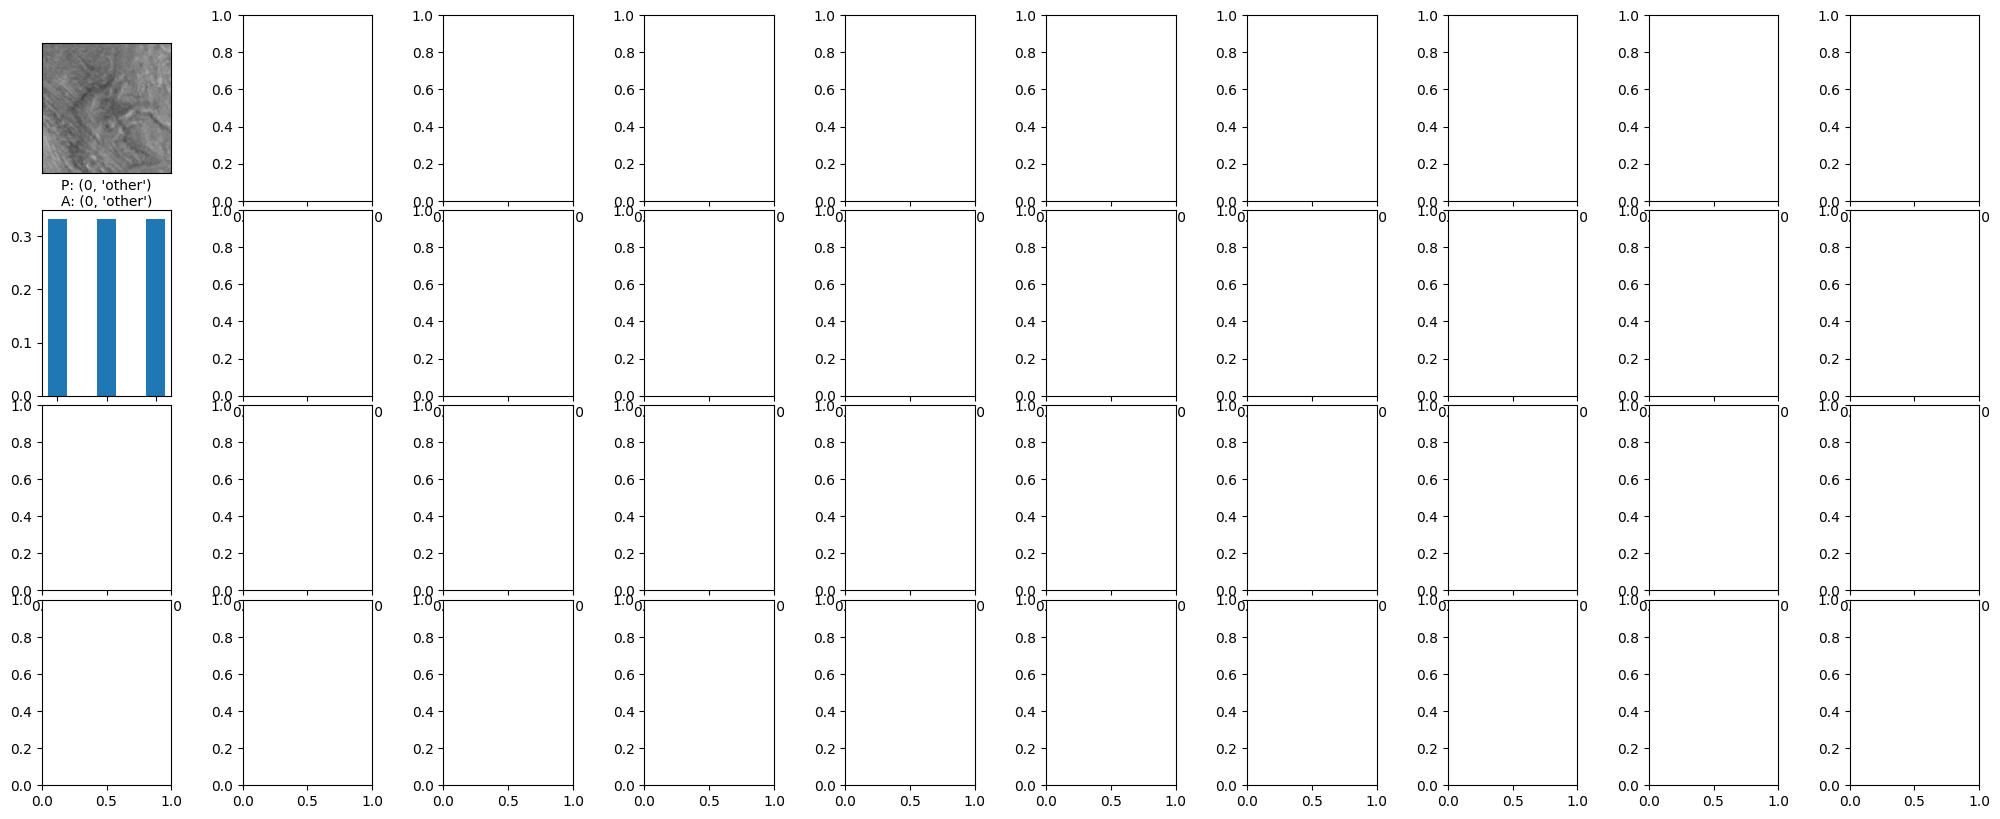

In [14]:
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(25, 10))
class_list = [0,2,4]

rand_list = list(randint(0,8,12))
for i in rand_list:
    class_list.append(i)
count = 0
j = 0
x,y = 0,1
image_count = 0
for i in test_ds:
    image_count = 0
    for k in i[1]:
        prediction = predictions[count]
        actual = np.argmax(k)
        print(prediction,actual)
        if np.isin(actual,class_list):

            axes[x][j].imshow(i[0][image_count])
            axes[x][j].set_xticks([])
            axes[x][j].set_yticks([])

            # Set the x axis label
            axes[x][j].set_xlabel(f"P: {np.argmax(prediction),data_dict[int(np.argmax(prediction))]}\nA: {actual, data_dict[actual]}",fontsize=10)

            # Add some space between subplots
            plt.subplots_adjust(wspace=0.55)
            plt.subplots_adjust(hspace=0.05)

            # Plot the predicted probabilities as a bar graph
            axes[y][j].bar([0,2,4],prediction)
            axes[y][j].set_xticks([0,2,4])
            axes[y][j].set_xticklabels([0,1,2,3,4,5,6,7], rotation=90, fontsize=8)

            class_list.remove(int(actual))

            j += 1
    
        image_count += 1
        count += 1

        if len(class_list) == 10:
            x,y,j=2,3,0
        if class_list == []:
            break
    if class_list == []:
        break